In [2]:
# -*- coding: utf-8 -*-
"""
From scratch implementation of the famous ResNet models.
The intuition for ResNet is simple and clear, but to code
it didn't feel super clear at first, even when reading Pytorch own
implementation. 

Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
*    2020-04-12 Initial coding
*    2022-12-20 Update comments, code revision, checked still works with latest PyTorch version
"""

import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    BATCH_SIZE = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    net = ResNet101(img_channel=3, num_classes=1000).to(device)  # Model on GPU/CPU
    x = torch.randn(BATCH_SIZE, 3, 224, 224).to(device)  # Move input tensor to same device
    
    y = net(x)  # Forward pass

    # check if two devices match
    print(x.device)  # Should match net.device
    print(next(net.parameters()).device)  # Should match x.device

    assert y.size() == torch.Size([BATCH_SIZE, 1000])  # Check output size
    print(y.size())

if __name__ == "__main__":
    test()


cuda:0
cuda:0
torch.Size([4, 1000])


In [3]:
import torch.optim as optim
from torchvision import datasets, transforms

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# example: Load ResNet50 model
model = ResNet50(img_channel=3, num_classes=10).to(device)  # 10 classes (change as needed)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy dataset (CIFAR-10)
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)



In [4]:
from tqdm import tqdm

# Training loop with tqdm progress bar
for epoch in range(2):  # Train for 2 epochs (change as needed)
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{2}")  # tqdm progress bar
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update tqdm with loss value
        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch+1}/2] - Final Loss: {loss.item():.4f}")


Epoch 1/2: 100%|█████████████████████████████████████████████████████████| 1563/1563 [07:29<00:00,  3.48it/s, loss=1.18]


Epoch [1/2] - Final Loss: 1.1760


Epoch 2/2: 100%|█████████████████████████████████████████████████████████| 1563/1563 [07:28<00:00,  3.48it/s, loss=1.24]

Epoch [2/2] - Final Loss: 1.2358


In [6]:
# Save model
torch.save(model.state_dict(), "resnet50.pth")

# Load model
model.load_state_dict(torch.load("resnet50.pth"))


<All keys matched successfully>

The CIFAR-10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each: 

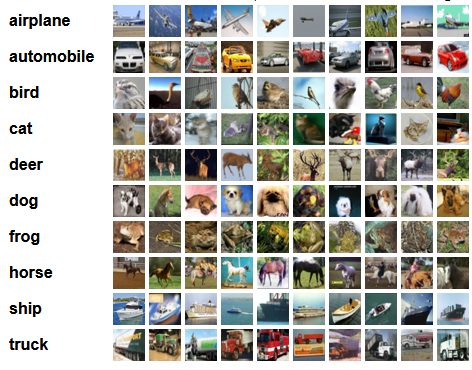

In [7]:
from PIL import Image

# Load an image of a horse
image = Image.open("horse.jpg")
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Predict
model.eval()
with torch.no_grad():
    output = model(image)
    predicted_class = torch.argmax(output, dim=1).item()

print(f"Predicted class: {predicted_class}")


Predicted class: 7


# 7 is horse, so the model is correct this time

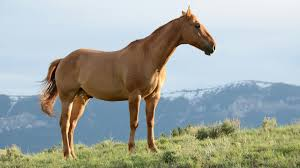

In [5]:
from IPython.display import Image
Image(filename='horse.jpg') 